# Predicting Particulate Matter (PM2.5) using CNN-LSTM Neural Network

## 1. Description
### 1.1 Technologies
* OS : MacOS 
* Programming Language : 
    * Script: Python 3.7.3
    * Web application: NodeJS v10.16.0
* Python Libraries : 
    * Pandas
    * Numpy
    * Matplotlib
    * TensorFlow
    * Scikit-learn
* Others:
    * Visual Studio Code
    * Jupyter Notebook

### 1.2 Dataset
* Dataset used is a real dataset from UCI Machine Learning titled “Beijing PM2.5 Data Data Set”.
* Metadata:

## 2. Architecture of CNN-LSTM Model
* The method used is to combine Convolutional Neural Network (CNN) for feature extraction and Long Short-Term Memory (LSTM) to predict PM2.5 concentrations in the air.
* Following are the architecture of CNN-LSTM model proposed by C.-J. Huang and P.-H. Kuo, 2018 (Figure 1) and the flowchart of PM2.5 prediction system (Figure 2).

![Figure 1](img/1.png)

![Figure 2](img/2.png)

## 3. Steps

In [145]:
# import all libraries needed
import os
import pandas as pd
import seaborn as sns 
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

### 3.1 Import Dataset

In [3]:
# definisikan dataset path
PATH = os.getcwd()
print(PATH)

DATASET_DIR_PATH = PATH + '/../data/'
print(DATASET_DIR_PATH)

DATASET_PATH = DATASET_DIR_PATH + 'PRSA_data.csv'
print(DATASET_PATH)

DATASET_PREPROCESSED_PATH = DATASET_DIR_PATH + 'PRSA_data_preprocessed.csv'
print(DATASET_PREPROCESSED_PATH)

/Users/mocatfrio/Documents/college/S2/first-semester/computational-intelligence-HT/computational-intelligence-2019/2019/final-project
/Users/mocatfrio/Documents/college/S2/first-semester/computational-intelligence-HT/computational-intelligence-2019/2019/final-project/../data/
/Users/mocatfrio/Documents/college/S2/first-semester/computational-intelligence-HT/computational-intelligence-2019/2019/final-project/../data/PRSA_data.csv
/Users/mocatfrio/Documents/college/S2/first-semester/computational-intelligence-HT/computational-intelligence-2019/2019/final-project/../data/PRSA_data_preprocessed.csv


In [4]:
# parse datetime
def custom_parser(year, month, day, hour):
    date_string = year + ' ' + month + ' ' + day + ' ' + hour
    return datetime.strptime(date_string, '%Y %m %d %H')

# read all column names 
cols = list(pd.read_csv(DATASET_PATH, nrows =1))
print('column names: {}'.format(cols))

# load data
# 1. parse datetime using custom parser
# 2. set datetime as index
# 3. drop column 'No'
df = pd.read_csv(DATASET_PATH, sep=',', header=0, low_memory=False, infer_datetime_format=True, 
                 parse_dates={'datetime':['year', 'month', 'day', 'hour']}, date_parser=custom_parser,
                 index_col=['datetime'],
                 usecols=[i for i in cols if i != 'No'])

column names: ['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']


In [5]:
# specify new column names
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [6]:
# get metadata of dataset
print('Number of Rows :', df.shape[0])
print('Number of Columns :', df.shape[1])
print('Attributes :', df.columns.to_list())
print('Time series start from :', df.index.min())
print('Time series end at :', df.index.max())

Number of Rows : 43824
Number of Columns : 8
Attributes : ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
Time series start from : 2010-01-01 00:00:00
Time series end at : 2014-12-31 23:00:00


In [7]:
# show data
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
datetime,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [8]:
# show data
df.tail()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
datetime,,,,,,,,
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0
2014-12-31 23:00:00,12.0,-21,-3.0,1034.0,NW,249.85,0,0


### 3.2 Prepare and Preprocess
#### 3.2.1 Fill Null Value

In [9]:
# cek null value
df.isnull().sum()

pollution    2067
dew             0
temp            0
press           0
wnd_dir         0
wnd_spd         0
snow            0
rain            0
dtype: int64

In [10]:
# cek data types
df.dtypes

pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object

In [11]:
# null value in this data marked with 'NA'
# mark all NA values with 0
df['pollution'].fillna(0, inplace=True)

In [12]:
# cek null value
df.isnull().sum()

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [13]:
# show data
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
datetime,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0


In [14]:
# the initial data of pollution (pm2.5 concentration) can't be 0 because it's used for prediction   
# so, we'll drop the first 24 hours or 1 day
df = df[24:]

In [15]:
# show data
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
datetime,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [16]:
df.to_csv(DATASET_PREPROCESSED_PATH)
print('exported successfully!')

exported successfully!


### 3.3 LSTM

In [17]:
# import the preprocessed data
df_process = pd.read_csv(DATASET_PREPROCESSED_PATH, header=0, index_col=0)

In [18]:
df_process.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
datetime,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [120]:
# save data values as array
val = df_process.values
print(val)

[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]


#### 3.3.1 Normalize Data

In [121]:
# convert wind direction (SE and NW) into integer
print(val[:, 4])
encoder = LabelEncoder()
val[:, 4] = encoder.fit_transform(val[:, 4])
print(val[:, 4])

# convert all datatype into float
val = val.astype('float32')

# normalize features with a range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_val = scaler.fit_transform(val)
print(scaled)

['SE' 'SE' 'SE' ... 'NW' 'NW' 'NW']
[2 2 2 ... 1 1 1]
[[0.12977867 0.35294122 0.24590163 ... 0.00229001 0.         0.        ]
 [0.14889336 0.36764708 0.24590163 ... 0.00381099 0.         0.        ]
 [0.15995975 0.4264706  0.22950819 ... 0.00533197 0.         0.        ]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.41399646 0.         0.        ]
 [0.00804829 0.2647059  0.24590163 ... 0.4208665  0.         0.        ]
 [0.01207243 0.2794118  0.26229507 ... 0.42621556 0.         0.        ]]


#### 3.3.2 Reframe Time Series Data into Supervised

In [122]:
# function to convert time series data into supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    if type(data) is list:
        n_vars = 1
    else:
        n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
#     input sequence (t-n, ..., t-1) 
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
#     forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
#     put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [123]:
# reframe as supervised learning
reframed = series_to_supervised(scaled_val, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [124]:
# We only need to predict the column pm2.5 concentration or pollution, so, we will drop all the unneeded columns 
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


#### 3.3.3 Split Data

In [125]:
# function to split data 
# as default, using first 1 year as train dataset

def split_data(data, is_horizontal=True, train_hours=365*24):
    if is_horizontal:
#         split into train and test datasets 
        if type(data) is not list:
            val = data.values
            train = val[:train_hours, :]
            test = val[train_hours:, :]
        else:
            train = data[:train_hours, :]
            test = data[train_hours:, :]

        return train, test
    else:
#         split into input and output
        train_X, train_y = data['train'][:, :-1], data['train'][:, -1]
        test_X, test_y = data['test'][:, :-1], data['test'][:, -1]
        return train_X, train_y, test_X, test_y

In [126]:
train, test = split_data(reframed)
print(len(train))
print(len(test))

8760
35039


In [127]:
data = {
    'train': train,
    'test': test
}

train_X, train_y, test_X, test_y = split_data (data, False)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

print(train_X)
print(train_y)

(8760, 8) (8760,) (35039, 8) (35039,)
[[0.12977867 0.35294122 0.24590163 ... 0.00229001 0.         0.        ]
 [0.14889336 0.36764708 0.24590163 ... 0.00381099 0.         0.        ]
 [0.15995975 0.4264706  0.22950819 ... 0.00533197 0.         0.        ]
 ...
 [0.         0.32352942 0.22950819 ... 0.10542597 0.         0.        ]
 [0.         0.32352942 0.16393442 ... 0.11229601 0.         0.        ]
 [0.         0.33823532 0.1967213  ... 0.12070411 0.         0.        ]]
[0.14889336 0.15995975 0.18209255 ... 0.         0.         0.0362173 ]


In [128]:
# we have to give a three-dimensional array as an input to your LSTM network
# so, first reshape input to be 3D [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


#### 3.3.4 Designing Network Architecture 
1. LSTM with 50 neurons in the first layer
2. 1 neuron in the dense or output layer to predict concentration of pm2.5
3. Model is fit for training epochs = 50 and batch size = 72 

In [129]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [130]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0590 - val_loss: 0.0527
Epoch 2/50
 - 1s - loss: 0.0420 - val_loss: 0.0569
Epoch 3/50
 - 1s - loss: 0.0245 - val_loss: 0.0478
Epoch 4/50
 - 1s - loss: 0.0164 - val_loss: 0.0347
Epoch 5/50
 - 1s - loss: 0.0150 - val_loss: 0.0222
Epoch 6/50
 - 1s - loss: 0.0149 - val_loss: 0.0188
Epoch 7/50
 - 1s - loss: 0.0148 - val_loss: 0.0171
Epoch 8/50
 - 1s - loss: 0.0146 - val_loss: 0.0160
Epoch 9/50
 - 1s - loss: 0.0146 - val_loss: 0.0154
Epoch 10/50
 - 1s - loss: 0.0146 - val_loss: 0.0149
Epoch 11/50
 - 1s - loss: 0.0145 - val_loss: 0.0144
Epoch 12/50
 - 1s - loss: 0.0145 - val_loss: 0.0139
Epoch 13/50
 - 1s - loss: 0.0145 - val_loss: 0.0137
Epoch 14/50
 - 1s - loss: 0.0145 - val_loss: 0.0137
Epoch 15/50
 - 1s - loss: 0.0145 - val_loss: 0.0137
Epoch 16/50
 - 1s - loss: 0.0144 - val_loss: 0.0135
Epoch 17/50
 - 1s - loss: 0.0144 - val_loss: 0.0136
Epoch 18/50
 - 1s - loss: 0.0144 - val_loss: 0.0135
Epoch 19/50
 - 1s - loss

In [131]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


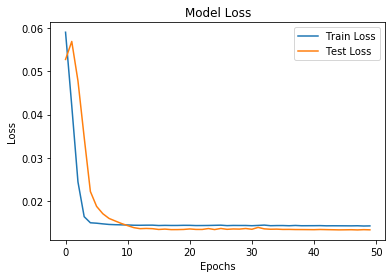

In [132]:
# plot history
pyplot.plot(history.history['loss'], label='Train Loss')
pyplot.plot(history.history['val_loss'], label='Test Loss')
pyplot.title('Model Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [133]:
# make a prediction
test_predict = model.predict(test_X)
print(test_predict)
print(test_predict.shape)

[[0.03536738]
 [0.03218446]
 [0.02143496]
 ...
 [0.00859005]
 [0.00855723]
 [0.00676628]]
(35039, 1)


In [134]:
# invert scaling for forecast
# reshape test_X into 2D
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X.shape)

inv_test_predict = concatenate((test_predict, test_X[:, 1:]), axis=1)
print(inv_test_predict)
print(inv_test_predict.shape)

(35039, 8)
[[0.03536738 0.33823532 0.1967213  ... 0.12757413 0.         0.        ]
 [0.03218446 0.33823532 0.1967213  ... 0.006101   0.         0.        ]
 [0.02143496 0.33823532 0.1967213  ... 0.0145091  0.         0.        ]
 ...
 [0.00859005 0.2647059  0.26229507 ... 0.40558836 0.         0.        ]
 [0.00855723 0.2647059  0.26229507 ... 0.41399646 0.         0.        ]
 [0.00676628 0.2647059  0.24590163 ... 0.4208665  0.         0.        ]]
(35039, 8)


In [135]:
inv_test_predict = scaler.inverse_transform(inv_test_predict)
print(inv_test_predict)

inv_test_predict = inv_test_predict[:, 0]
print(inv_test_predict)

[[ 35.155178  -17.         -7.        ...  75.1         0.
    0.       ]
 [ 31.991354  -17.         -7.        ...   4.02        0.
    0.       ]
 [ 21.30635   -17.         -7.        ...   8.94        0.
    0.       ]
 ...
 [  8.5385065 -22.         -3.0000002 ... 237.78        0.
    0.       ]
 [  8.505885  -22.         -3.0000002 ... 242.7         0.
    0.       ]
 [  6.7256856 -22.         -4.        ... 246.72        0.
    0.       ]]
[35.155178  31.991354  21.30635   ...  8.5385065  8.505885   6.7256856]


In [136]:
# invert scaling for actual
# reshape test_y into 2D
test_y = test_y.reshape((len(test_y), 1))
print(test_y.shape)

inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
print(inv_y)
print(inv_y.shape)

inv_y = scaler.inverse_transform(inv_y)
print(inv_y)

inv_y = inv_y[:, 0]
print(inv_y)

(35039, 1)
[[0.03118712 0.33823532 0.1967213  ... 0.12757413 0.         0.        ]
 [0.02012072 0.33823532 0.1967213  ... 0.006101   0.         0.        ]
 [0.01911469 0.33823532 0.1967213  ... 0.0145091  0.         0.        ]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.40558836 0.         0.        ]
 [0.00804829 0.2647059  0.26229507 ... 0.41399646 0.         0.        ]
 [0.01207243 0.2647059  0.24590163 ... 0.4208665  0.         0.        ]]
(35039, 8)
[[ 31.        -17.         -7.        ...  75.1         0.
    0.       ]
 [ 20.        -17.         -7.        ...   4.02        0.
    0.       ]
 [ 19.        -17.         -7.        ...   8.94        0.
    0.       ]
 ...
 [ 10.        -22.         -3.0000002 ... 237.78        0.
    0.       ]
 [  8.        -22.         -3.0000002 ... 242.7         0.
    0.       ]
 [ 12.        -22.         -4.        ... 246.72        0.
    0.       ]]
[31. 20. 19. ... 10.  8. 12.]


In [143]:
# calculate MAE, RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_test_predict))
mae = mean_absolute_error(inv_y, inv_test_predict)

print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 26.465
Test MAE: 13.327


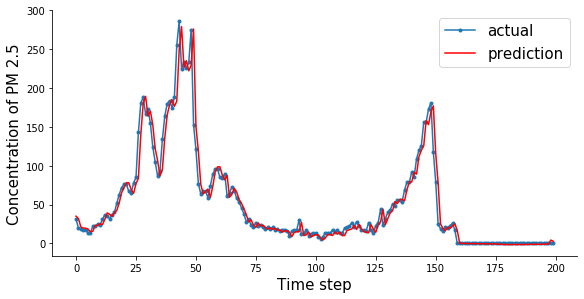

In [146]:
aa = [x for x in range(200)]
pyplot.figure(figsize=(8,4))
pyplot.plot(aa, inv_y[:200], marker='.', label="actual")
pyplot.plot(aa, inv_test_predict[:200], 'r', label="prediction")
pyplot.tight_layout()
sns.despine(top=True)
pyplot.subplots_adjust(left=0.07)
pyplot.ylabel('Concentration of PM 2.5', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show();